In [1]:
import os
import numpy as np
from typing import Sequence, List, Tuple

from string import punctuation
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

%matplotlib inline

punctuation += '«»–—…“”'

# Чтение и предобработка данных

In [2]:
train, y_train, test, y_test = [], [], [], []

for filename in os.listdir('aclImdb/train/pos'):
    with open('aclImdb/train/pos/' + filename, 'r') as f:
        train.append(f.read())
        y_train.append(1)
        
for filename in os.listdir('aclImdb/train/neg'):
    with open('aclImdb/train/neg/' + filename, 'r') as f:
        train.append(f.read())
        y_train.append(0)
        
for filename in os.listdir('aclImdb/test/pos'):
    with open('aclImdb/test/pos/' + filename, 'r') as f:
        test.append(f.read())
        y_test.append(1)
        
for filename in os.listdir('aclImdb/test/neg'):
    with open('aclImdb/test/neg/' + filename, 'r') as f:
        test.append(f.read())
        y_test.append(0)

In [3]:
print(tuple(map(len, (train, y_train, test, y_test))))

(25000, 25000, 25000, 25000)


In [4]:
def preprocess(text: str) -> str:
    return text.strip().lower()

def tokenize(text: str) -> List[str]:
    tokens = []
    for token in word_tokenize(text):
        token_stripped = token.strip(punctuation)
        if token_stripped:
            tokens.append(token_stripped)
    return tokens

In [5]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                   tokenizer=tokenize, ngram_range=(1, 3),
                                   max_df=0.75, min_df=25, max_features=10000)

data = tfidf_vectorizer.fit_transform(train + test)
X_train = data[:len(train), :]
X_test = data[len(train):, :]

In [6]:
print(X_train.todense().shape, X_test.todense().shape)

(25000, 10000) (25000, 10000)


# Функция для ручного подсчёта метрик

In [7]:
def get_binary_metrics(true: Sequence[float], pred: Sequence[float]) -> Tuple[float]:
    assert len(true) == len(pred), 'Длины входных массивов не совпадают.'
    assert all(0. <= x <= 1. for x in true), 'В массиве ответов есть числа вне интервала от 0 до 1.'
    assert all(0. <= x <= 1. for x in pred), 'В массиве предсказаний есть числа вне интервала от 0 до 1.'
    
    tp, fp, fn = 0, 0, 0
    
    # На случай, если на вход поступят вероятности классов.
    pred = np.round(pred)
    
    for t, p in zip(true, pred):
        if t == p == 1.:
            tp += 1
            continue
        
        if t == 0. and p == 1.:
            fp += 1
            continue
        
        if t == 1. and p == 0.:
            fn += 1
            continue
    
    p = tp / (tp + fp) if tp + fp > 0 else 0
    r = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2*p*r / (p + r) if p + r > 0 else 0
    
    return p, r, f1

In [8]:
def print_binary_metrics(true: Sequence[float], pred: Sequence[float]):
    p, r, f1 = get_binary_metrics(true, pred)
    print(f'Precision:\t{p:.2f}\nRecall:\t\t{r:.2f}\nF1-measure:\t{f1:.2f}')

# Отрисовка ROC-кривой

In [9]:
def print_roc_curve(true: Sequence[float], pred: Sequence[float]):
    fpr, tpr, _ = roc_curve(true, pred)
    plt.plot(fpr, tpr, marker='.', label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    print(f'Area under the ROC curve: {roc_auc_score(y_test, pred):.2f}')

# Наивный Байес

In [10]:
mnnb = MultinomialNB().fit(X_train, y_train)
pred_mnnb = mnnb.predict(X_test)

print(classification_report(y_test, pred_mnnb))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.86      0.87      0.86     12500

   micro avg       0.86      0.86      0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [11]:
print_binary_metrics(y_test, pred_mnnb)

Precision:	0.86
Recall:		0.87
F1-measure:	0.86


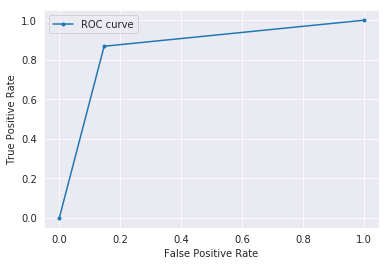

Area under the ROC curve: 0.86


In [12]:
print_roc_curve(y_test, pred_mnnb)

# Логистическая регрессия

In [13]:
logreg = LogisticRegression().fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

print(classification_report(y_test, pred_logreg))

/home/ALPHA/sykhrannov-ne/.virtualenvs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [14]:
print_binary_metrics(y_test, pred_logreg)

Precision:	0.89
Recall:		0.90
F1-measure:	0.89


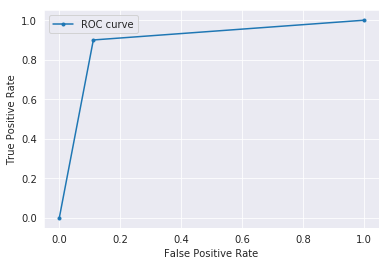

Area under the ROC curve: 0.89


In [15]:
print_roc_curve(y_test, pred_logreg)

# Метод опорных векторов

In [16]:
svc = LinearSVC().fit(X_train, y_train)
pred_svc = svc.predict(X_test)

print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [17]:
print_binary_metrics(y_test, pred_svc)

Precision:	0.89
Recall:		0.89
F1-measure:	0.89


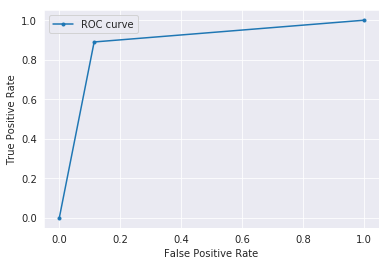

Area under the ROC curve: 0.89


In [18]:
print_roc_curve(y_test, pred_svc)

# Примеры классов

Лучшей моделью (по совокупности метрик) оказалась логистическая регрессия. Возьмём индексы текстов с минимальным/максимальным значением предсказанной вероятности класса 1: это будут тексты, классифицированные моделью как наиболее отрицательные или наиболее положительные соответственно. Посмотрим, какие тексты находятся лежат по этим индексам.

In [19]:
probas_logreg = logreg.predict_proba(X_test)
probas_logreg = sorted(list(enumerate(probas_logreg[:, 1])), key = lambda x: x[1])

## Положительные примеры

In [21]:
pos_examples = probas_logreg[-15:]

for idx, _ in pos_examples:
    print(test[idx] + '\n')

Jim Henson's The Muppet Movie is a charming, funny and brilliant film that can be watched AND enjoyed by adults and kids. I feel this is my favorite childhood film because it combines great characters, great story, and great wit that it is irresistable. The plot involves Kermit the frog (puppeteered and voiced by Henson) in his odyssey across America to follow his dream in Hollywood. Along the way, he meets Fozzie Bear, The Great Gonzo (my favorite), Miss Piggy, Rolf, and DR. Teeth and the electric mayhem.<br /><br />This film has so many good things I can't even say them. But it is memorable and every time I think of a puppet or muppet, I will think of this film. Look for cameos from Mel Brooks, Dom DeLouise, Paul Williams, Madeline Kahn, Bob Hope, Richard Pryor, Steve martin, Edgar Bergen (and Charlie McCarthey), Elliot Gould, Carol Kane and the great Orson Welles. Excellent and spectacular, one of the best films of the 70's. A++

I saw this film at Telluride Film Festival in 1997, w

## Отрицательные примеры

In [22]:
neg_examples = probas_logreg[:15]

for idx, _ in neg_examples:
    print(test[idx] + '\n')

This was truly horrible. Bad acting, bad writing, bad effects, bad scripting, bad camera shots, bad filming, bad characters, bad music, bad editing, bad casting, bad storyline, bad ... well, you get the idea. It was just, just ... what's the word? Oh yeah ... BAD!

This is just the same old crap that is spewed from amateur idiots who have no clue how to make a movie--gee maybe that's why it is a straight-to-video wanna-be movie!<br /><br />I guess it is my fault for actually spending money to see it (one of the worst decisions I have ever made). What a waste. I usually like B movies, some of them are actually quite good--but this is just too ridiculous and stupid to even be funny.<br /><br />The losers that made this junk deserve to be put out of business for wasting everyone's time and money making a movie that obviously doesn't even deserve to be on film! These so-called movie makers have absolutely NO talent!<br /><br />Stupid plot, horrible acting (especially the drag queens--what 